# Ethereum Price Prediction using TinyTimeMixer

This notebook demonstrates how to forecast Ethereum (ETH) price movements using the TinyTimeMixer (TTM) model, a time series forecasting model.

### What this notebook does:
- Fetches 6 months of hourly ETH price data from Yahoo Finance
- Loads and configures the pre-trained TinyTimeMixer model
- Generates 96-hour (4-day) price predictions
- Visualizes historical data and forecasts

### This notebook does NOT:
- Presume any accuracy with regard to real-world price prediction. It's purely for educational purposes.

### Model configuration:
- **Context Length**: 512 hours (~21 days of historical data)
- **Prediction Length**: 96 hours (4 days ahead)
- **Data Frequency**: Hourly
- **Model**: IBM Granite TimeSeries TTM-R2

---

## 1. Installation and Setup

First, let's install the required packages. We'll use the `granite-tsfm` library which provides the TinyTimeMixer implementation, and `yfinance` for fetching cryptocurrency data.

In [ ]:
!pip install "granite-tsfm[notebooks]==0.2.23" yfinance -q

## 2. Import Libraries

Now let's import all the necessary libraries for data manipulation, visualization, and machine learning.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import torch
import warnings
warnings.filterwarnings('ignore')

from tsfm_public import TimeSeriesForecastingPipeline, TinyTimeMixerForPrediction

## 3. Hardware Check

Let's check what hardware we're working with. The model can run on both CPU and GPU, though GPU will be faster for inference.

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Libraries imported")
print(f"Device: {device.upper()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

## 4. Configuration Parameters

Here we define the key parameters for our forecasting:

- **MODEL_NAME**: The pre-trained TinyTimeMixer model
- **CONTEXT_LENGTH**: How much historical data the model looks at (512 hours ≈ 21 days)
- **PREDICTION_LENGTH**: How far ahead we predict (96 hours = 4 days)
- **DATA_PERIOD**: How much historical data to fetch (6 months)
- **DATA_INTERVAL**: Frequency of data points (1 hour)
- **LOOKBACK_PLOT_HOURS**: How much recent data to show in visualization (48 hours)

In [ ]:
MODEL_NAME = "ibm-granite/granite-timeseries-ttm-r2"
CONTEXT_LENGTH = 512
PREDICTION_LENGTH = 96
DATA_PERIOD = "6mo"
DATA_INTERVAL = "1h"
LOOKBACK_PLOT_HOURS = 48

## 5. Data Acquisition

Now let's fetch Ethereum price data using the `yfinance` library. We'll get 6 months of hourly data, clean it, and prepare it for the model.

We'll focus on the closing price as our target variable.

In [ ]:
def fetch_eth_data(period, interval):
    
    eth = yf.Ticker("ETH-USD")
    data = eth.history(period=period, interval=interval).reset_index()

    data = data.rename(columns={'Datetime': 'time', 'Close': 'eth_price_close'})
    data['time'] = pd.to_datetime(data['time']).dt.tz_localize(None)
    data = data[['time', 'eth_price_close']].dropna().reset_index(drop=True)

    print(f"Fetched {len(data)} ETH price records")
    print(f"Range: {data['time'].min()} to {data['time'].max()}")
    print(f"Current price: ${data['eth_price_close'].iloc[-1]:.2f}")

    return data

eth_data = fetch_eth_data(period=DATA_PERIOD, interval=DATA_INTERVAL)

## 6. Model Loading

Now to load the pre-trained TinyTimeMixer model, which has already been trained on a large corpus of Bitcoin time series data and can adapt to various forecasting tasks.

The model expects:
- **num_input_channels=1**: We're forecasting a single variable (ETH price)
- **Context length of 512**: The model will look at the last 512 hours of data
- **Prediction length of 96**: It will forecast 96 hours into the future

In [ ]:
print(f"Loading TinyTimeMixer model on {device.upper()}...")
model = TinyTimeMixerForPrediction.from_pretrained(
    MODEL_NAME,
    num_input_channels=1
).to(device)

model.eval()
print(f"Model loaded with {sum(p.numel() for p in model.parameters()):,} parameters")

## 7. Price Prediction

With this function, the model will:

1. Take the last 512 hours of ETH price data as context
2. Use its learned patterns to forecast the next 96 hours
3. Output predictions

In [ ]:
def predict_eth_price(data, model, context_length, prediction_length):

    # Prepare data for TTM (requires exactly 512 points)
    if len(data) < context_length:
        raise ValueError(f"Need at least {context_length} data points")

    input_data = data.tail(context_length).copy().reset_index(drop=True)

    # Create forecasting pipeline
    pipeline = TimeSeriesForecastingPipeline(
        model=model,
        timestamp_column="time",
        id_columns=[],
        target_columns=["eth_price_close"],
        prediction_length=prediction_length,
        explode_forecasts=False,
        freq="H",
        device=device
    )

    # Generate predictions with timing
    print("Generating predictions...")
    if device == "cuda":
        torch.cuda.empty_cache()
        start_event = torch.cuda.Event(enable_timing=True)
        end_event = torch.cuda.Event(enable_timing=True)
        start_event.record()

    with torch.no_grad():
        forecast = pipeline(input_data)

    if device == "cuda":
        end_event.record()
        torch.cuda.synchronize()
        inference_time = start_event.elapsed_time(end_event) / 1000
        print(f"GPU inference time: {inference_time:.2f}s")

        # Memory stats
        current_mem = torch.cuda.memory_allocated() / 1e9
        peak_mem = torch.cuda.max_memory_allocated() / 1e9
        print(f"GPU Memory - Current: {current_mem:.2f}GB, Peak: {peak_mem:.2f}GB")

    # Extract predictions
    if 'eth_price_close_prediction' in forecast.columns:
        predictions = forecast['eth_price_close_prediction'].iloc[0]
    else:
        pred_cols = [col for col in forecast.columns if 'prediction' in col.lower()]
        if pred_cols:
            predictions = forecast[pred_cols[0]].iloc[0]
        else:
            raise ValueError("Could not find prediction column in forecast")

    return predictions, input_data

# Generate predictions using pre-loaded model
predictions, input_data = predict_eth_price(eth_data, model,
                                            context_length=CONTEXT_LENGTH,
                                            prediction_length=PREDICTION_LENGTH)
current_price = input_data['eth_price_close'].iloc[-1]

print(f"Generated {len(predictions)} predictions")
print(f"Current: ${current_price:.2f}")
print(f"Next hour: ${predictions[0]:.2f}")
print(f"24 hours: ${predictions[23]:.2f}")
print(f"Final ({PREDICTION_LENGTH}h): ${predictions[-1]:.2f}")

## 8. Basic Results Visualization and Analysis

Let's create a visualization of our predictions and analyze the results. The chart will show:

- **Historical ETH prices** (blue line): Recent price movements for context
- **Predicted prices** (red dashed line): The model's 96-hour forecast
- **Reference lines**: Current price level and prediction start point


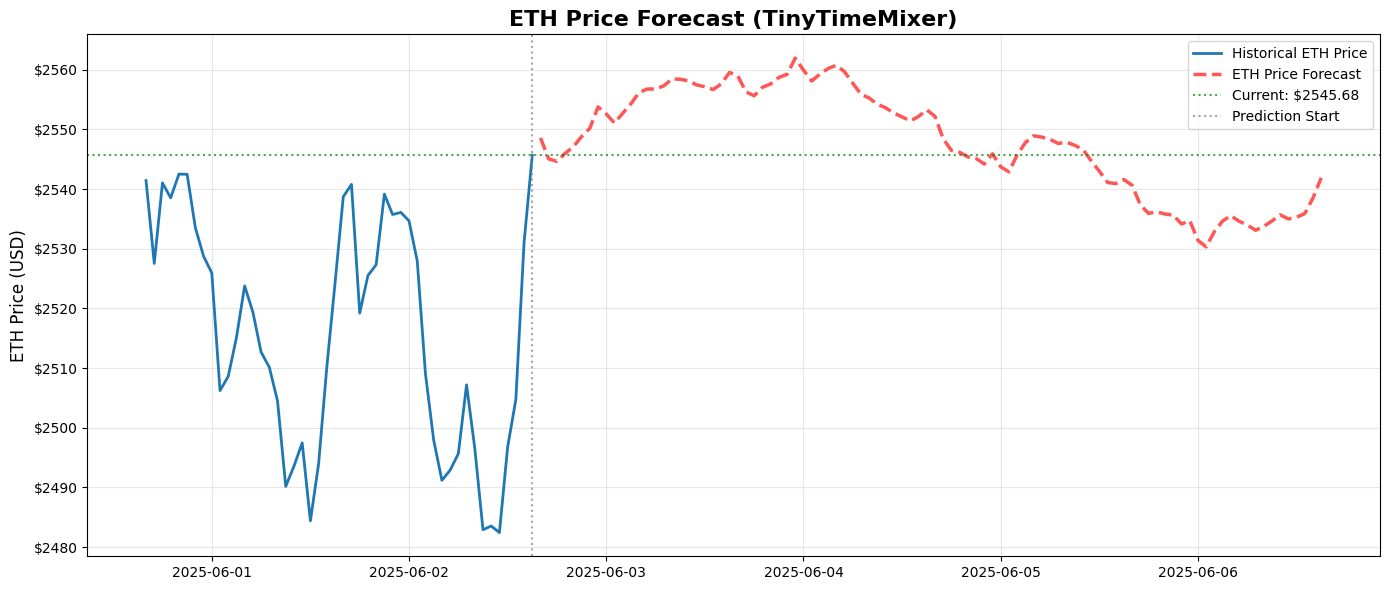


PREDICTION SUMMARY
Current Price: $2545.68
96h Forecast: $2541.89
Expected Change: -0.15%
Volatility: $8.90


In [ ]:
def plot_predictions(input_data, predictions, lookback_hours):

    # Prepare data for plotting
    hist_data = input_data.tail(lookback_hours)
    current_price = input_data['eth_price_close'].iloc[-1]

    # Create future timestamps - Based on the actual number of predictions
    last_time = input_data['time'].iloc[-1]
    future_times = pd.date_range(
        start=last_time + pd.Timedelta(hours=1),
        periods=len(predictions),
        freq='H'
    )

    # Create plot
    fig, ax = plt.subplots(figsize=(14, 6))

    # Plot historical data
    ax.plot(hist_data['time'], hist_data['eth_price_close'],
           label='Historical ETH Price', color='#1f77b4', linewidth=2)

    # Plot predictions
    ax.plot(future_times, predictions,
           label='ETH Price Forecast', color='#ff4444',
           linestyle='--', linewidth=2.5, alpha=0.9)

    # Add reference lines
    ax.axhline(y=current_price, color='green', linestyle=':',
              alpha=0.7, label=f'Current: ${current_price:.2f}')
    ax.axvline(x=last_time, color='gray', linestyle=':',
              alpha=0.7, label='Prediction Start')

    # Styling
    ax.set_title('ETH Price Forecast (TinyTimeMixer)', fontsize=16, fontweight='bold')
    ax.set_ylabel('ETH Price (USD)', fontsize=12)
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:.0f}'))

    plt.tight_layout()
    plt.show()

    # Print summary
    change_pct = ((predictions[-1] - current_price) / current_price) * 100
    volatility = np.std(predictions)

    print(f"\nPREDICTION SUMMARY")
    print(f"{'='*18}")
    print(f"Current Price: ${current_price:.2f}")
    print(f"{PREDICTION_LENGTH}h Forecast: ${predictions[-1]:.2f}") # Use variable
    print(f"Expected Change: {change_pct:+.2f}%")
    print(f"Volatility: ${volatility:.2f}")

plot_predictions(input_data, predictions, lookback_hours=LOOKBACK_PLOT_HOURS)


### References

- [TinyTimeMixer Paper](https://arxiv.org/abs/2401.03955)
- [IBM Granite TimeSeries Models](https://huggingface.co/ibm-granite) (at Hugging Face)
- [Time Series Forecasting with Transformers](https://huggingface.co/docs/transformers/model_doc/time_series_transformer) (at Hugging Face)